## Coding Discussion 6
### Alia Abdelkader

##### Setup

In [1]:
# Data Management/Investigation
import os
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data
from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation
from sklearn.model_selection import cross_validate # Cross validation
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Change working directory to the location of the cloned repository, where the data file is located
os.chdir('/Users/Alia/Documents/Github/coding_discussions_ppol564_fall2021/06_coding_discussion')

#### Import and Check Data

Training Data: (24996, 5)




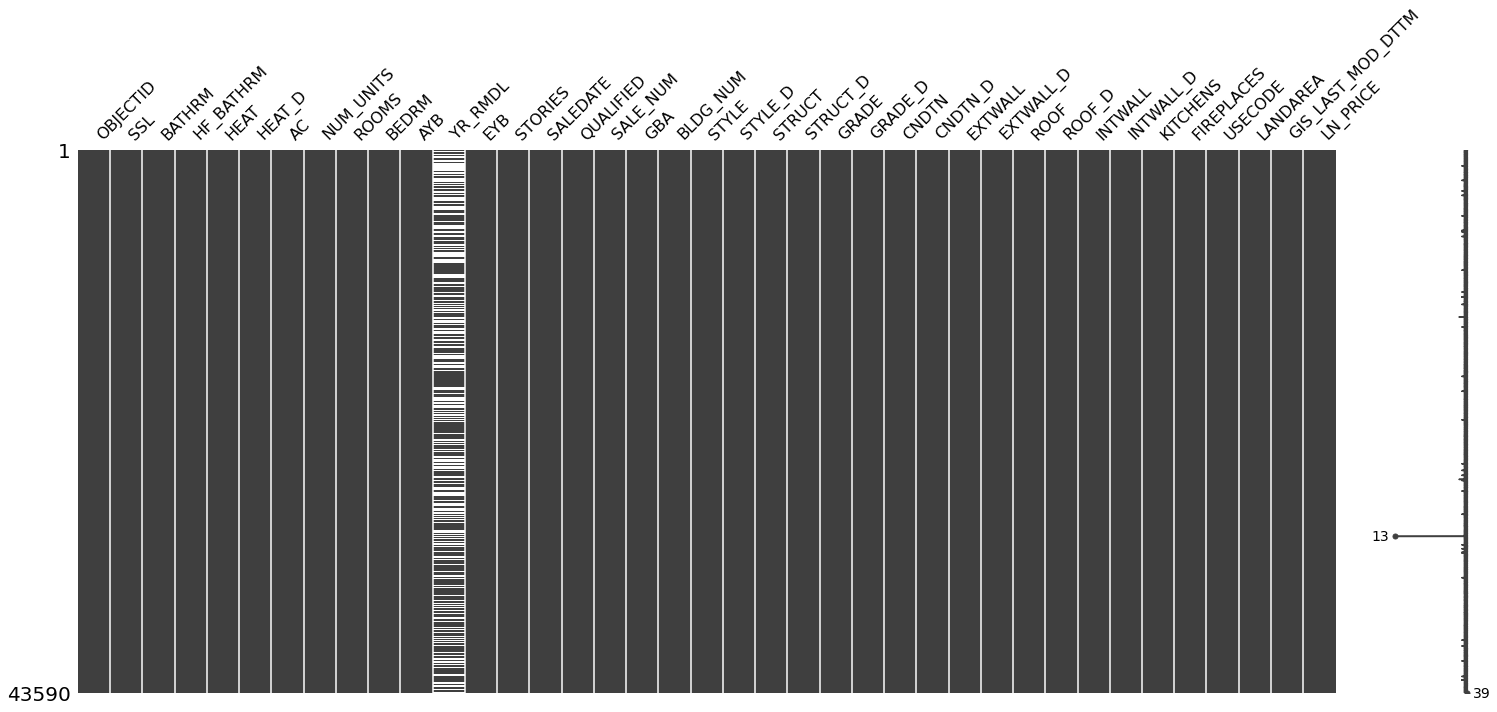

In [2]:
# Import data on Housing Prices in DC (Train and Test)
dat = pd.read_csv("train_data.csv")
dat_test = pd.read_csv("test_data.csv")
dat.shape

# Available features
list(dat)

# Look at **missingness** in the data: Issue we're missing information on the outcome `PRICE`
miss.matrix(dat)

# Include only houses that have been sold
dat = dat[dat.LN_PRICE > 0]

# Set up training Data
dat = dat.dropna() # Deal with missing values (drop NAs)
dat = dat.replace([np.inf, -np.inf, -0], 0) # Replace float inf values with a 0

train_y = dat['LN_PRICE'] # OUTCOME: log selling price
train_X = dat[['BEDRM','BATHRM','CNDTN','GBA','LANDAREA']] # PREDICTORS: Number of bedrooms, bathrooms, condition code, gross building area, and land area
train_X['GBA'] = np.log(train_X['GBA'])
train_X['LANDAREA'] = np.log(train_X['LANDAREA'])


# Look at the training data
print(f"Training Data: {train_X.shape}")
print("\n")

#### Plot the data

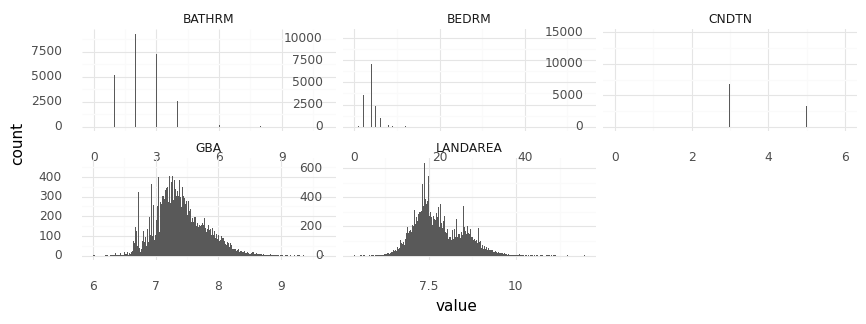

<ggplot: (8770146312075)>

In [3]:
# Plot feature distributions 
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
) 

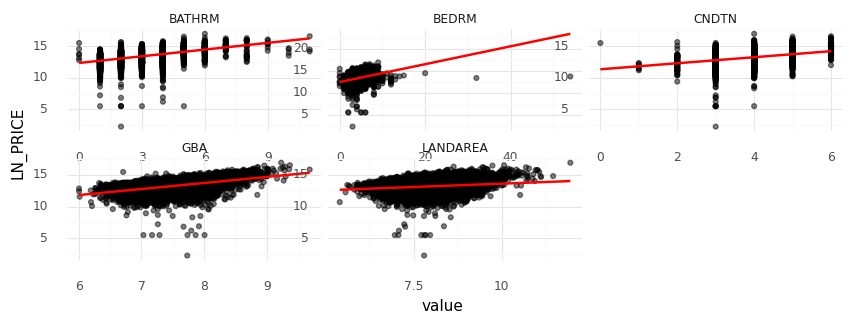

<ggplot: (8770128054233)>

In [4]:
# Plot the variables against the outcome

D = train_X.copy()
D['LN_PRICE'] = train_y

(
    ggplot(D.melt(id_vars=["LN_PRICE"]),
           aes(x="value",y="LN_PRICE"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3))
)

#### Preprocessing

In [5]:
# Scale the training data
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,BEDRM,BATHRM,CNDTN,GBA,LANDAREA
0,0.074074,0.272727,0.833333,0.308304,0.354963
1,0.074074,0.181818,0.500000,0.468906,0.546214
2,0.074074,0.181818,0.500000,0.539095,0.345348
3,0.074074,0.272727,0.666667,0.332728,0.365790
4,0.055556,0.272727,0.666667,0.391938,0.279556
...,...,...,...,...,...
24991,0.037037,0.090909,0.500000,0.238064,0.144743
24992,0.055556,0.181818,0.666667,0.373990,0.292711
24993,0.074074,0.181818,0.666667,0.486138,0.283199
24994,0.055556,0.272727,0.666667,0.345113,0.213070


#### Modeling

Types of models to specify
- Linear Regression
- KNN
- Decision Tree
- Bagging
- Random Forest

In [6]:
# Create a KFold generator to specify the break points that should be used when training the model
fold_generator = KFold(n_splits=5, shuffle=True,random_state=123)

# Set mean squared error (MSE) as the performance metric for the models
use_metrics = ["neg_mean_squared_error"]

#### Run the Models

In [7]:
# Linear Model
lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

# KNN
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

# Decision Tree
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)
mod = DTree(max_depth=3) # Initialize the modeling object
mod.fit(train_X,train_y) # Fit the model

# Bagging
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

# Random Forest
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

#### Compare the Models

In [8]:
# Compare Models

# Outputs are stored as a dictionary
print(lm_scores)
print("\n")

# Collect all metrics of interest
collect_scores = dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
print(collect_scores)

{'fit_time': array([0.02831292, 0.01634502, 0.00683594, 0.0052011 , 0.00441432]), 'score_time': array([0.00326014, 0.00587511, 0.00205588, 0.00215983, 0.00181413]), 'test_neg_mean_squared_error': array([-0.40563983, -0.39385511, -0.3735582 , -0.38122323, -0.37589002])}


   Model       MSE
0     lm  0.405640
1     lm  0.393855
2     lm  0.373558
3     lm  0.381223
4     lm  0.375890
5    knn  0.423056
6    knn  0.412773
7    knn  0.401930
8    knn  0.407032
9    knn  0.396451
10    dt  0.701438
11    dt  0.675887
12    dt  0.664344
13    dt  0.700390
14    dt  0.686093
15   bag  0.434961
16   bag  0.440684
17   bag  0.421153
18   bag  0.428321
19   bag  0.416972
20    rf  0.407288
21    rf  0.409811
22    rf  0.389205
23    rf  0.396831
24    rf  0.383460


#### Plot the model comparison

['lm', 'rf', 'knn', 'bag', 'dt']


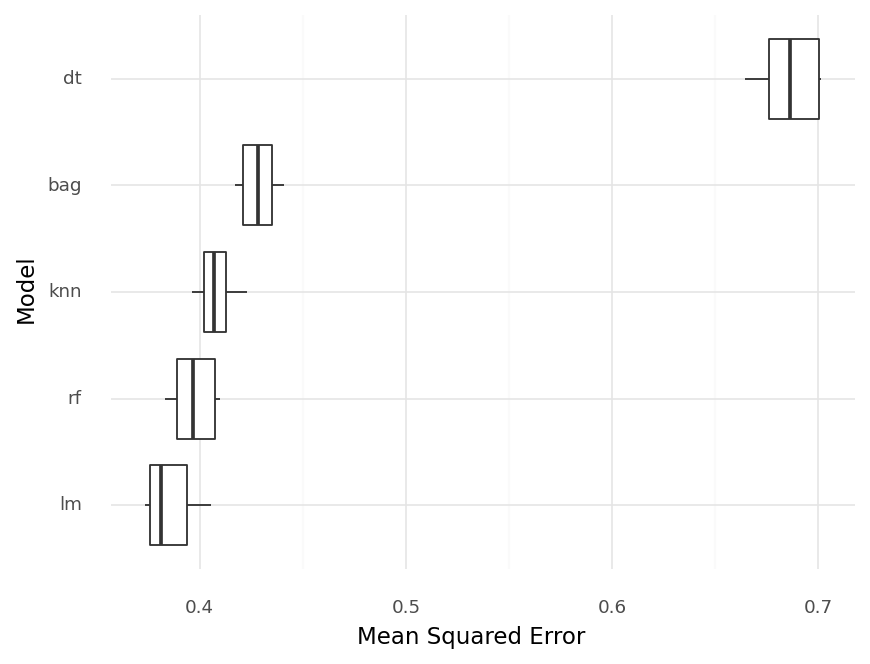

<ggplot: (8770132664269)>

In [9]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

print(order)

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

It appears that the linear model performed the best, with the lowest MSE out of all the models (0.373558).

#### Model Tuning: K-Nearest Neighbors

In [10]:
# Set 'n_neighbors' for K-Nearest Neighbors Model
set_k = dict()
for k in [1,5,10,50,100,250]:
    score = cross_validate(KNN(n_neighbors=k),
                           train_X,train_y,
                           cv = fold_generator,
                           scoring =use_metrics)
    s = score['test_neg_mean_squared_error']
    set_k[k] = s.mean()

print(set_k)

{1: -0.6666340869457636, 5: -0.4082482480393832, 10: -0.3779243376741578, 50: -0.3592608766562132, 100: -0.35915325075955795, 250: -0.3634887463004687}


In [11]:
mod = KNN() # Initialize the model class
print("Available Tuning Parameters")
print(mod.get_params()) # Report all the available tunning parameters for the model

# Create a dictionary of all the tuning parameter values that we want to explore
knn_tune_params = {'n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]}
print("\n")

# Wrap the model method in the `GridSearchCV()` class
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

# Fit the model as per usual
tune_knn.fit(train_X,train_y)

# Once fit, the model reports back the best fitting parameters.
print("KNN Best Params")
print(tune_knn.best_params_)
print("\n")

print("KNN Best Score")
print(tune_knn.best_score_)
print("\n")

# We can also gather information on the other attempts
print("KNN CV Results")
print(tune_knn.cv_results_)

Available Tuning Parameters
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


KNN Best Params
{'n_neighbors': 75}


KNN Best Score
-0.35835287185774467


KNN CV Results
{'mean_fit_time': array([0.32710543, 0.35611525, 0.29892492, 0.33508205, 0.27206731,
       0.30146155, 0.44869905, 0.2805634 ]), 'std_fit_time': array([0.06060169, 0.0684956 , 0.04614616, 0.07509643, 0.03087322,
       0.08710459, 0.11317138, 0.07437364]), 'mean_score_time': array([0.14757638, 0.25567417, 0.41681757, 0.52149978, 0.49190941,
       0.87412834, 1.11629019, 1.654526  ]), 'std_score_time': array([0.02329939, 0.0261697 , 0.07384773, 0.0845534 , 0.06840735,
       0.12999307, 0.17420805, 0.46294309]), 'param_n_neighbors': masked_array(data=[1, 10, 25, 35, 50, 75, 100, 250],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [

#### Model Tuning: Decision Tree

In [12]:
# Report all the available tunning parameters for the model
print("Available Tuning Parameters")
print(DTree().get_params())
print("\n")

tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(10)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

# Fit the model
tune_dt.fit(train_X,train_y)

print("Decision Tree Best Params")
print(tune_dt.best_params_)
print("\n")

print("Decision Tree Best Score")
print(tune_dt.best_score_)

Available Tuning Parameters
{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


Decision Tree Best Params
{'max_depth': 7}


Decision Tree Best Score
-0.3742214054067102


#### Model Tuning: Random Forest

In [13]:
# Report all the available tunning parameters for the model
print("Available Tuning Parameters")
print(RF().get_params())
print("\n")

rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000],
              'max_features': [1,2]} # Only have three total.

tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

# Fit the model
tune_rf.fit(train_X,train_y)

print("Random Forest Best Params")
print(tune_rf.best_params_)
print("\n")

print("Random Forest Best Score")
print(tune_rf.best_score_)

Available Tuning Parameters
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Random Forest Best Params
{'max_depth': 3, 'max_features': 2, 'n_estimators': 500}


Random Forest Best Score
-0.40192448486862353


#### Modeling

In [20]:
# Create a pipeline

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=123)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BEDRM','BATHRM','CNDTN','GBA','LANDAREA'])])

# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

# (4) Specify the models and their repsective tuning parameters.
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]

# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space,
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

# Check the best fit score from the scan
print("Best Model Score")
print(search.best_score_) # Mean out-of-sample (CV) error
print("\n")

# Check the best model parameters
print("Best Model Params")
print(search.best_params_)

Best Model Score
-0.36075298929349076


Best Model Params
{'model': KNeighborsRegressor(n_neighbors=30), 'model__n_neighbors': 30}


#### Test Performance

Test Data: (8328, 5)


Prediction MSE
5.829348254277912


Prediction R-Squared
-8.619306245649934


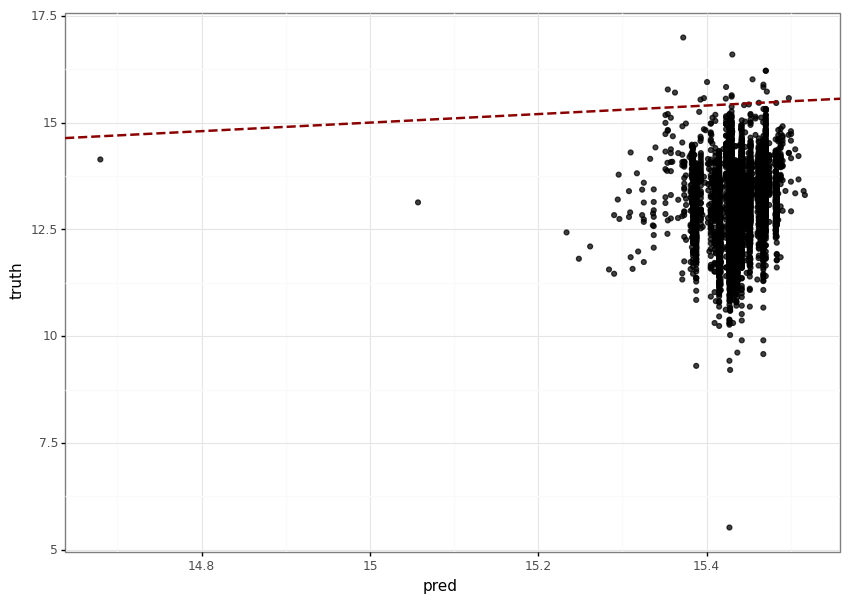

<ggplot: (8770126753058)>

In [21]:
# Set up test data 
dat_test = dat_test.dropna()
dat_test = dat_test.replace([np.inf, -np.inf, -0], 0)

test_y = dat_test['LN_PRICE'] 
test_X = dat_test[['BEDRM','BATHRM','CNDTN','GBA','LANDAREA']]
test_X['GBA'] = np.log(test_X['GBA'])
test_X['LANDAREA'] = np.log(test_X['LANDAREA'])

# Look at the shape of the test data
print(f"Test Data: {test_X.shape}")
print("\n")

# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

print("Prediction MSE")
print(m.mean_squared_error(test_y,pred_y))
print("\n")

print("Prediction R-Squared")
print(m.r2_score(test_y,pred_y))

# Visualize
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

I've tried a lot of different parameters with these models and though the MSE is low for the best performing model (KNN with 30 neighbors), the R-Squared value is always negative. Through some research, I've found that the Sklearn R-Squared function can return a negative value if the model could be arbitrarily worse. The fit line on the chart above doesn't seem to be the best fit for the actual predictions on the plot. I'm going to spend some more time figuring out what the issue here could be, because it seems like the model itelf actually performs reasonably well.